In [1]:
import torch
import os
import numpy as np
import torch.nn.init as init
from torchvision import datasets, transforms
from torch import optim, nn
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import logging
import math

/Users/dongpochen/opt/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_dir = './meta_out'

In [3]:
train_settings = {
    "combined_1": {"epochs": 4, "lr": 0.005, "loss_type": ["distribution", "follow_leader"], "alpha": 1.},
}

## Dataloader

In [4]:
tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])

In [5]:
def task_dataloader(task_num):
    task_dir = {0: [0, 1], 1: [2, 3], 2: [4, 5], 3: [6, 7], 4:[8, 9]}

    train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=tf)

    indices = [i for i, (_, label) in enumerate(train_dataset) if label in task_dir[task_num]]
    dataset = Subset(train_dataset, indices)
    task_train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    indices = [i for i, (_, label) in enumerate(test_dataset) if label in task_dir[task_num]]
    dataset = Subset(test_dataset, indices)
    task_test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return task_train_loader, task_test_loader

def load_all_data():
    train_dataset = datasets.MNIST(root='./data', train=True, transform=tf, download=True)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, test_loader

In [ ]:
class SoftmaxDataset(torch.utils.data.Dataset):
    def __init__(self, batch_size, seq_len, num_features, num_samples):
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.num_features = num_features
        self.num_samples = num_samples
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        logits = np.random.rand(self.batch_size, self.seq_len, self.num_features)
        inputs = torch.tensor(self.softmax(logits), dtype=torch.float32)
        targets = torch.tensor([2.0] * self.batch_size, dtype=torch.float32)
        return inputs, targets
    
    @staticmethod
    def softmax(x):
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return e_x / e_x.sum(axis=-1, keepdims=True)

In [6]:
def adjust_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.75 * param_group['lr']

# Model

In [13]:
class MetaLearner(nn.Module):
    def __init__(self):
        super(MetaLearner, self).__init__()

        self.linear = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 2)
        )

    def forward(self, task_num):
        x = torch.tensor([task_num], dtype=torch.float32).unsqueeze(0)
        x = self.linear(x)
        weights = torch.sigmoid(x) * 0.5 + 1
        return weights

In [8]:
class MLP_Enhance(nn.Module):
    def __init__(self, out_dim=10, in_channel=1, img_sz=28, hidden_dim=400):
        super(MLP_Enhance, self).__init__()
        self.in_dim = in_channel*img_sz*img_sz
        self.linear = nn.Sequential(
            nn.Linear(self.in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
        )
        self.last = nn.Sequential(
            nn.Linear(hidden_dim, out_dim),
            nn.Softmax(dim=1)
        )
        self.init_weights()

    def init_weights(self):
        for layer in self.linear:
            if isinstance(layer, nn.Linear):
                init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                init.constant_(layer.bias, 0)
        last_linear = self.last[0]
        init.xavier_normal_(last_linear.weight)
        init.constant_(last_linear.bias, 0)


    def features(self, x):
        x = self.linear(x.view(-1,self.in_dim))
        return x

    def logits(self, x):
        x = self.last(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x

In [9]:
train_loader, test_loader = load_all_data()
task_dataloaders = {}
for task in range(0, 5):
    train_dl, test_ld = task_dataloader(task)
    task_dataloaders[task] = (train_dl, test_ld)

In [10]:
def cal_acc(model, dataloader, device):
    model.eval()
    correct, total = 0., 0.
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [14]:
def plot_acc_history(all_accuracies):
    plt.figure(figsize=(18, 12))

    for i, task_accuracies in enumerate(all_accuracies):
        plt.subplot(2, 3, i+1)
        for task, accs in task_accuracies.items():
            plt.plot(accs,'-', label=f'Task {task}')
        plt.title(f'Accuracy per Mini-Batch for Task {i}')
        plt.xlabel('Mini-Batch Number')
        plt.ylabel('Accuracy (%)')
        plt.ylim(-5, 105)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


def plot_task_acc_history(all_accuracies, save_name, epochs):
    for task in [0, 1, 2, 3, 4]:
        if (task == 0):
            task_history = []
        else:
            task_history =  [0] * (epochs * task)
        for i, task_accuracies in enumerate (all_accuracies):
            if (i >= task):
                task_history.extend(task_accuracies[task])
                    
        plt.plot(task_history, '-', label=f'Task {task}')

    plt.xlabel('Mini-Batch Number')
    plt.ylabel('Accuracy (%)')
    plt.ylim(-5, 105)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_name) 
    plt.show()

In [15]:
meta_learner = MetaLearner().to(device)
meta_optimizer = torch.optim.Adam(meta_learner.parameters(), lr=0.001)


# Parameters
batch_size = 32
seq_len = 128
num_features = 10
num_samples = 1000

# Dataset and DataLoader
dataset = SoftmaxDataset(batch_size, seq_len, num_features, num_samples)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

def pretrain_meta_learner(meta_learner, optimizer_M, dataloader):
    pretrain_epochs = 5
    criterion = nn.MSELoss()
    for epoch in range(pretrain_epochs):
        for inputs, targets in dataloader:
            meta_learner.train()
            inputs = inputs.squeeze(0) 
            targets = targets.squeeze(0)
            
            outputs = meta_learner(inputs)
            loss = criterion(outputs, targets)
            
            optimizer_M.zero_grad()
            loss.backward()
            optimizer_M.step()

pretrain_meta_learner()

# Train

In [49]:
def train(model, task_num, criterion, prev_model, epoches = 4, lr = 0.005, loss_type = ["Baseline"]):
    follower = MLP_Enhance()
    follower = follower.to(device)
    follower.load_state_dict(model.state_dict())
    criterion = nn.CrossEntropyLoss()
    optimizer_F = torch.optim.Adam(follower.parameters(), lr)
        
    train_loader = task_dataloaders[task_num][0]
    task_accuracies = {task: [] for task in range(task_num + 1)}
    distribution_factor = 20

    valid_out_dim = task_num * 2 + 2
    logging.info(f"##########Task {task_num}##########")
    for e in range(epoches):
        logging.info(f"Epoch {e}")
        batch_num = 0
        for images, labels in train_loader:
            follower.train()
            meta_learner.eval()
            images, labels = images.to(device), labels.to(device)
            outputs = follower(images)
            with torch.no_grad():
                meta_weights = meta_learner(task_num)[0]
            leading_factor, sub_leading_factor = meta_weights[0], meta_weights[1]

            if (batch_num % 10 == 0):
                print(f"leading_factor {leading_factor.item():.4f}, sub_leading_factor: {sub_leading_factor.item():.4f}")
            reg_loss = 0
            if ("distribution" in loss_type):
                random_data = torch.rand(256, 1, 28, 28).to(device)
                random_data = (random_data - 0.5) / 0.5
                random_target = torch.randint(0, 10, (256,), dtype=torch.int64).to(device)
                fake_output = follower(random_data)
                reg_loss += distribution_factor * criterion(fake_output, random_target)

            if ("follow_leader" in loss_type):
                for k, mod in enumerate(prev_model):
                    with torch.no_grad():
                        leader_output = mod(images)
                    diff = torch.mean(torch.abs(leader_output[:,k*2:k * 2 + 2] - outputs[:,k*2:k * 2 + 2]))

                    if (k == task_num - 1):
                        reg_loss += leading_factor * diff
                    else:
                        reg_loss += sub_leading_factor * diff
            loss = criterion(outputs[:,:valid_out_dim], labels) + reg_loss
            optimizer_F.zero_grad()
            loss.backward()
            optimizer_F.step()
            batch_num += 1

            meta_learner.train()
            model.eval()
            with torch.no_grad():
                outputs = follower(images)
            meta_optimizer.zero_grad()
            meta_weights = meta_learner(task_num)[0]
            leading_factor, sub_leading_factor = meta_weights[0], meta_weights[1]
            meta_reg_loss = 0

            if "distribution" in loss_type:
                random_data = torch.rand(256, 1, 28, 28).to(device)
                random_data = (random_data - 0.5) / 0.5
                random_target = torch.randint(0, 10, (256,), dtype=torch.int64).to(device)
                fake_output = follower(random_data)
                meta_reg_loss += distribution_factor * criterion(fake_output, random_target)

            if "follow_leader" in loss_type:
                for k, mod in enumerate(prev_model):
                    with torch.no_grad():
                        leader_output = mod(images)
                    diff = torch.mean(torch.abs(leader_output[:, k * 2:k * 2 + 2] - outputs[:, k * 2:k * 2 + 2]))
                    if k == task_num - 1:
                        meta_reg_loss += leading_factor * diff
                    else:
                        meta_reg_loss += sub_leading_factor * diff

            meta_loss = meta_reg_loss
            meta_loss.backward()
            meta_optimizer.step()

        adjust_learning_rate(optimizer_F)

        avg_acc = 0
        log_message = []
        log_message.append(f"Epoch: {e}, ")
        for task in range(task_num + 1):
            acc = cal_acc(follower, task_dataloaders[task][0], device)
            avg_acc += acc
            task_accuracies[task].append(acc * 100)
            log_message.append(f"Task {task} acc: {acc * 100:.4f}")

        logging.info(', '.join(log_message) + f", Task avg acc:{avg_acc*100/(task_num + 1):.4f}")
    
    return follower, task_accuracies

In [50]:
def setup_logging(file_name):
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s - %(levelname)s - %(message)s',
                        handlers=[
                            logging.FileHandler(file_name),
                            logging.StreamHandler()
                        ],
                        force=True)
    
def train_split_task(task_name):
    print(f"Training on {task_name}")
    prev_model = []
    model = MLP_Enhance()
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    settings = train_settings[task_name]
    epochs, lr, loss_type = settings['epochs'], settings['lr'], settings['loss_type']

    file_name = f"{output_dir}/{task_name}_epochs={epochs}"

    log_file_name = file_name + '.log'
    img_file_name = file_name + '.png'
    if True:
    #if os.path.exists(log_file_name) == False:
        setup_logging(log_file_name)
        all_accuracies = []
        for task in [0, 1, 2, 3, 4]:
            model, task_accuracies = train(model, task, criterion, prev_model, epoches = epochs, lr = lr, loss_type = loss_type)
            all_accuracies.append(task_accuracies)
            prev_model.append(model)

        plot_task_acc_history(all_accuracies, img_file_name, epochs)

2024-05-31 10:11:27,774 - INFO - ##########Task 0##########
2024-05-31 10:11:27,775 - INFO - Epoch 0


Training on combined_1
leading_factor 1.0211, sub_leading_factor: 1.0465
leading_factor 1.0211, sub_leading_factor: 1.0464
leading_factor 1.0211, sub_leading_factor: 1.0464
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463


2024-05-31 10:11:38,411 - INFO - Epoch: 0, , Task 0 acc: 95.4959, Task avg acc:95.4959
2024-05-31 10:11:38,414 - INFO - Epoch 1


leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463


2024-05-31 10:11:48,709 - INFO - Epoch: 1, , Task 0 acc: 97.4091, Task avg acc:97.4091
2024-05-31 10:11:48,711 - INFO - Epoch 2


leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463


2024-05-31 10:11:58,334 - INFO - Epoch: 2, , Task 0 acc: 98.8600, Task avg acc:98.8600
2024-05-31 10:11:58,335 - INFO - Epoch 3


leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463
leading_factor 1.0211, sub_leading_factor: 1.0463


2024-05-31 10:12:08,867 - INFO - Epoch: 3, , Task 0 acc: 99.2666, Task avg acc:99.2666
2024-05-31 10:12:08,889 - INFO - ##########Task 1##########
2024-05-31 10:12:08,890 - INFO - Epoch 0


leading_factor 1.0023, sub_leading_factor: 1.0087
leading_factor 1.0022, sub_leading_factor: 1.0087
leading_factor 1.0021, sub_leading_factor: 1.0086
leading_factor 1.0020, sub_leading_factor: 1.0085
leading_factor 1.0020, sub_leading_factor: 1.0085
leading_factor 1.0019, sub_leading_factor: 1.0084
leading_factor 1.0018, sub_leading_factor: 1.0084
leading_factor 1.0017, sub_leading_factor: 1.0083
leading_factor 1.0016, sub_leading_factor: 1.0082
leading_factor 1.0016, sub_leading_factor: 1.0082


2024-05-31 10:12:21,302 - INFO - Epoch: 0, , Task 0 acc: 4.9904, Task 1 acc: 84.7074, Task avg acc:44.8489
2024-05-31 10:12:21,306 - INFO - Epoch 1


leading_factor 1.0015, sub_leading_factor: 1.0082
leading_factor 1.0015, sub_leading_factor: 1.0081
leading_factor 1.0014, sub_leading_factor: 1.0080
leading_factor 1.0014, sub_leading_factor: 1.0080
leading_factor 1.0013, sub_leading_factor: 1.0079
leading_factor 1.0013, sub_leading_factor: 1.0079
leading_factor 1.0012, sub_leading_factor: 1.0078
leading_factor 1.0012, sub_leading_factor: 1.0078
leading_factor 1.0011, sub_leading_factor: 1.0078
leading_factor 1.0011, sub_leading_factor: 1.0077


2024-05-31 10:12:33,434 - INFO - Epoch: 1, , Task 0 acc: 0.0558, Task 1 acc: 86.9265, Task avg acc:43.4912
2024-05-31 10:12:33,436 - INFO - Epoch 2


leading_factor 1.0011, sub_leading_factor: 1.0077
leading_factor 1.0011, sub_leading_factor: 1.0077
leading_factor 1.0010, sub_leading_factor: 1.0076
leading_factor 1.0010, sub_leading_factor: 1.0076
leading_factor 1.0010, sub_leading_factor: 1.0075
leading_factor 1.0009, sub_leading_factor: 1.0075
leading_factor 1.0009, sub_leading_factor: 1.0075
leading_factor 1.0009, sub_leading_factor: 1.0074
leading_factor 1.0009, sub_leading_factor: 1.0074
leading_factor 1.0008, sub_leading_factor: 1.0074


2024-05-31 10:12:44,912 - INFO - Epoch: 2, , Task 0 acc: 0.0159, Task 1 acc: 87.3920, Task avg acc:43.7039
2024-05-31 10:12:44,914 - INFO - Epoch 3


leading_factor 1.0008, sub_leading_factor: 1.0073
leading_factor 1.0008, sub_leading_factor: 1.0073
leading_factor 1.0008, sub_leading_factor: 1.0073
leading_factor 1.0008, sub_leading_factor: 1.0072
leading_factor 1.0007, sub_leading_factor: 1.0072
leading_factor 1.0007, sub_leading_factor: 1.0072
leading_factor 1.0007, sub_leading_factor: 1.0072
leading_factor 1.0007, sub_leading_factor: 1.0071
leading_factor 1.0007, sub_leading_factor: 1.0071
leading_factor 1.0007, sub_leading_factor: 1.0071


2024-05-31 10:12:57,705 - INFO - Epoch: 3, , Task 0 acc: 1.2277, Task 1 acc: 85.7713, Task avg acc:43.4995
2024-05-31 10:12:57,750 - INFO - ##########Task 2##########
2024-05-31 10:12:57,752 - INFO - Epoch 0


leading_factor 1.0000, sub_leading_factor: 1.0008
leading_factor 1.0000, sub_leading_factor: 1.0008
leading_factor 1.0000, sub_leading_factor: 1.0008
leading_factor 1.0000, sub_leading_factor: 1.0008
leading_factor 1.0000, sub_leading_factor: 1.0007
leading_factor 1.0000, sub_leading_factor: 1.0007
leading_factor 1.0000, sub_leading_factor: 1.0007
leading_factor 1.0000, sub_leading_factor: 1.0006
leading_factor 1.0000, sub_leading_factor: 1.0006


2024-05-31 10:13:13,177 - INFO - Epoch: 0, , Task 0 acc: 27.0408, Task 1 acc: 0.0000, Task 2 acc: 89.2152, Task avg acc:38.7520
2024-05-31 10:13:13,182 - INFO - Epoch 1


leading_factor 1.0000, sub_leading_factor: 1.0006
leading_factor 1.0000, sub_leading_factor: 1.0006
leading_factor 1.0000, sub_leading_factor: 1.0006
leading_factor 1.0000, sub_leading_factor: 1.0005
leading_factor 1.0000, sub_leading_factor: 1.0005
leading_factor 1.0000, sub_leading_factor: 1.0005
leading_factor 1.0000, sub_leading_factor: 1.0005
leading_factor 1.0000, sub_leading_factor: 1.0005
leading_factor 1.0000, sub_leading_factor: 1.0005


2024-05-31 10:13:26,970 - INFO - Epoch: 1, , Task 0 acc: 13.4008, Task 1 acc: 5.3191, Task 2 acc: 96.7223, Task avg acc:38.4808
2024-05-31 10:13:26,974 - INFO - Epoch 2


leading_factor 1.0000, sub_leading_factor: 1.0004
leading_factor 1.0000, sub_leading_factor: 1.0004
leading_factor 1.0000, sub_leading_factor: 1.0004
leading_factor 1.0000, sub_leading_factor: 1.0004
leading_factor 1.0000, sub_leading_factor: 1.0004
leading_factor 1.0000, sub_leading_factor: 1.0004
leading_factor 1.0000, sub_leading_factor: 1.0004
leading_factor 1.0000, sub_leading_factor: 1.0004
leading_factor 1.0000, sub_leading_factor: 1.0004


2024-05-31 10:13:41,317 - INFO - Epoch: 2, , Task 0 acc: 33.9126, Task 1 acc: 0.1912, Task 2 acc: 97.0366, Task avg acc:43.7135
2024-05-31 10:13:41,323 - INFO - Epoch 3


leading_factor 1.0000, sub_leading_factor: 1.0003
leading_factor 1.0000, sub_leading_factor: 1.0003
leading_factor 1.0000, sub_leading_factor: 1.0003
leading_factor 1.0000, sub_leading_factor: 1.0003
leading_factor 1.0000, sub_leading_factor: 1.0003
leading_factor 1.0000, sub_leading_factor: 1.0003
leading_factor 1.0000, sub_leading_factor: 1.0003
leading_factor 1.0000, sub_leading_factor: 1.0003
leading_factor 1.0000, sub_leading_factor: 1.0003


2024-05-31 10:13:56,688 - INFO - Epoch: 3, , Task 0 acc: 6.5131, Task 1 acc: 2.1526, Task 2 acc: 95.7705, Task avg acc:34.8120
2024-05-31 10:13:56,713 - INFO - ##########Task 3##########
2024-05-31 10:13:56,714 - INFO - Epoch 0


leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000


2024-05-31 10:14:17,532 - INFO - Epoch: 0, , Task 0 acc: 16.0316, Task 1 acc: 5.5768, Task 2 acc: 0.3772, Task 3 acc: 98.6595, Task avg acc:30.1613
2024-05-31 10:14:17,536 - INFO - Epoch 1


leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000


2024-05-31 10:14:36,089 - INFO - Epoch: 1, , Task 0 acc: 3.5395, Task 1 acc: 4.2636, Task 2 acc: 1.7241, Task 3 acc: 99.5477, Task avg acc:27.2688
2024-05-31 10:14:36,093 - INFO - Epoch 2


leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000


2024-05-31 10:14:53,691 - INFO - Epoch: 2, , Task 0 acc: 5.8753, Task 1 acc: 2.0196, Task 2 acc: 4.7055, Task 3 acc: 99.0378, Task avg acc:27.9096
2024-05-31 10:14:53,693 - INFO - Epoch 3


leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000


2024-05-31 10:15:10,982 - INFO - Epoch: 3, , Task 0 acc: 15.2503, Task 1 acc: 0.5568, Task 2 acc: 5.4508, Task 3 acc: 99.2270, Task avg acc:30.1212
2024-05-31 10:15:11,003 - INFO - ##########Task 4##########
2024-05-31 10:15:11,004 - INFO - Epoch 0


leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000


2024-05-31 10:15:30,855 - INFO - Epoch: 0, , Task 0 acc: 37.3645, Task 1 acc: 3.8231, Task 2 acc: 0.0269, Task 3 acc: 0.0329, Task 4 acc: 71.5778, Task avg acc:22.5650
2024-05-31 10:15:30,856 - INFO - Epoch 1


leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000


2024-05-31 10:15:50,564 - INFO - Epoch: 1, , Task 0 acc: 27.9416, Task 1 acc: 19.4648, Task 2 acc: 4.1218, Task 3 acc: 0.3618, Task 4 acc: 72.0788, Task avg acc:24.7938
2024-05-31 10:15:50,566 - INFO - Epoch 2


leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000


2024-05-31 10:16:10,410 - INFO - Epoch: 2, , Task 0 acc: 34.3192, Task 1 acc: 26.0721, Task 2 acc: 0.3502, Task 3 acc: 0.9951, Task 4 acc: 71.7391, Task avg acc:26.6951
2024-05-31 10:16:10,414 - INFO - Epoch 3


leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000
leading_factor 1.0000, sub_leading_factor: 1.0000


2024-05-31 10:16:30,107 - INFO - Epoch: 3, , Task 0 acc: 27.0169, Task 1 acc: 11.5941, Task 2 acc: 10.8836, Task 3 acc: 2.7961, Task 4 acc: 77.0465, Task avg acc:25.8674


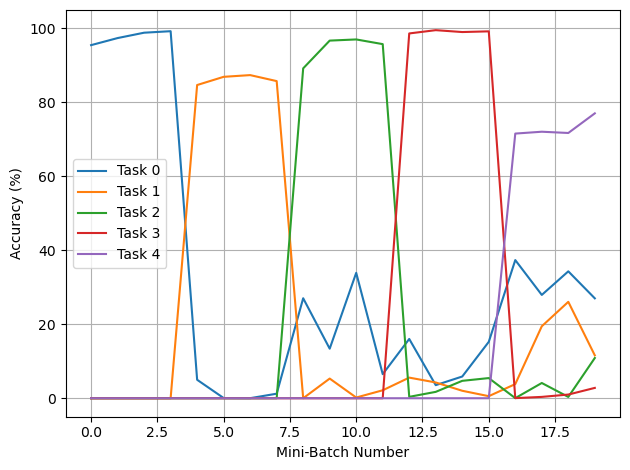

In [51]:
for key in train_settings.keys():
    train_split_task(key)

KeyError: 'l2'

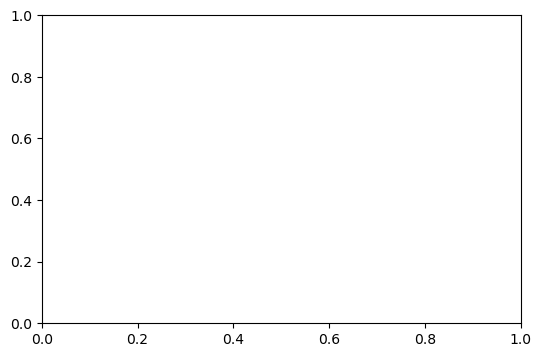

In [52]:
from PIL import Image
import matplotlib.pyplot as plt
import math

ncols = 3
nrows = math.ceil(len(train_settings.keys()) / 3.)

plt.figure(figsize=(21, 4 * nrows))  # Adjust the figure size based on the number of rows
for i, key in enumerate(train_settings.keys()):
    plt.subplot(nrows, ncols, i + 1)

    settings = train_settings[key]
    epochs, lr, l2, loss_type, factor = settings['epochs'], settings['lr'], settings['l2'], settings['loss_type'], settings['factor']

    file_name = f"{output_dir}/{key}_epochs={epochs}_lr={lr}_factor={factor}_l2={l2}.png"
    try:
        with Image.open(file_name) as img:
            plt.imshow(img)
            plt.title(f"{key}_factor={factor}.png")
            plt.axis('off')
    except FileNotFoundError:
        print(f"Error: The file '{file_name}' does not exist.")
plt.tight_layout()
plt.show()  # Move plt.show() outside the loop to display all subplots at once
